# Amenability Model Training (RandomForestClassifier)

Code for training RandomForestClassifier for method amenability inference

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import joblib
import pandas as pd
import time
import scipy.stats as stats
from collections import Counter


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer


from IPython.display import display, clear_output
sys.path.append('./tools/')
from tools import tools

rTools=tools()


In [2]:
#File path definitions
modelEvalPath="./modelsAssessment/amenability"
MLModelsPath="./models/amenability"
trainingDataFile="./dataSets/amenability/methodAmenability_trainingData_vd.pkl"



# **Data preprocessing**

In [3]:
# Loading of training data
data = joblib.load(trainingDataFile)
print(data["description"])
training_data=pd.concat([data['features'],data['target']], axis=1)
training_data



    This dataset contains information on the amenability of chemical compounds to a 
    QuEChERS–HPLC–ESI–HRMS analytical method. Compounds that are recovered are considered amenable, 
    whereas those lost at any stage of the analytical workflow are regarded as not amenable.
  
    ================================   ==============
    Number of instances: 	 	3819
    Instances info: 	 		3819x1
    Features dimensionality: 	 	3819x217
    Features (Molecular descriptors): 	real, integers
    Target (Amenability): 		bool
        	Amenable (TRUE):	889
        	No amenable (FALSE):	2930
    ================================   ==============

    Keys
    -------
        features : dataframe (3819, 217)
        target: dataframe (3819,1)
        feature_names: dataset column names.
        target_name: target variable name.
        instances_info: dataframe (3819, 1) 
            SMILES
        description: str
            Full dataset description

    Notes
    -----
        - Amenabil

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_unbrch_alkane,fr_urea,MID_N,MID_O,MID_H,MID_X,apol,bpol,LogS,Amenability
0,3.282407,3.282407,0.173611,-0.229167,0.516994,12.857143,424.550,423.542,419.599511,44,...,0,0,0.000000,0.000000,8.293857,8.293857,19.256793,7.903207,-4.137362,False
1,3.261574,3.261574,0.310185,0.310185,0.640241,11.000000,345.654,343.638,341.688998,38,...,0,0,0.000000,0.000000,6.650712,6.650712,16.873586,7.526414,-3.348831,False
2,3.816036,3.816036,0.560326,0.560326,0.252201,45.000000,641.700,623.556,635.650873,108,...,0,0,0.000000,0.000000,10.513490,10.513490,50.342274,26.337726,-6.590764,False
3,3.263889,3.263889,0.104167,-0.104167,0.591453,12.000000,345.654,343.638,341.688998,38,...,0,0,0.000000,0.000000,6.618718,6.618718,16.873586,7.526414,-3.705171,False
4,3.708519,3.708519,0.636620,0.636620,0.570356,39.500000,427.800,415.704,423.767249,72,...,0,0,0.000000,0.000000,6.953121,6.953121,33.561516,17.558484,-4.613754,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3814,5.255345,5.255345,0.765000,0.765000,0.631387,10.857143,184.198,176.134,184.063663,68,...,0,0,4.153874,2.016303,6.170176,0.000000,26.706344,11.471656,-3.582296,True
3815,5.185972,5.185972,0.819444,0.819444,0.635946,10.181818,147.177,138.105,147.068414,56,...,0,0,2.180501,2.003590,4.184091,0.000000,22.933137,12.474863,-1.836841,False
3816,2.213843,2.213843,1.363709,1.363709,0.584088,10.666667,248.397,240.333,247.978813,74,...,0,0,0.000000,0.000000,6.092071,0.000000,34.074344,15.405656,-4.033588,False
3817,2.148750,2.148750,1.368889,1.368889,0.706263,10.333333,230.404,224.356,229.935234,62,...,0,0,0.000000,0.000000,8.053935,0.000000,28.960758,13.399242,-2.773187,False


In [4]:
Counter(training_data.Amenability)

Counter({False: 2930, True: 889})

# Preliminary Cleaning

In [5]:
exploring_data=training_data.copy()
exploring_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3819 entries, 0 to 3818
Columns: 218 entries, MaxAbsEStateIndex to Amenability
dtypes: bool(1), float64(111), int64(106)
memory usage: 6.3 MB


In [6]:
#Remove duplicate and null features
exploring_data_T_summary=exploring_data.describe().T
zero_vals=list(dict.fromkeys(list(exploring_data_T_summary[exploring_data_T_summary['count']==0].index)
+list(exploring_data_T_summary[exploring_data_T_summary['max']==0.0 ].index)
+list(exploring_data_T_summary[list(exploring_data_T_summary.duplicated(['mean','std','min','max']))].index)
    ))
exploring_data=exploring_data.drop(zero_vals,axis=1)
exploring_data.drop(columns=["Amenability"]).columns.to_frame().to_csv(os.path.join(MLModelsPath,"Amenability_molecularDescriptors.vd.tsv"),sep="\t",index=False)
exploring_data

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_unbrch_alkane,fr_urea,MID_N,MID_O,MID_H,MID_X,apol,bpol,LogS,Amenability
0,3.282407,0.173611,-0.229167,0.516994,12.857143,424.550,423.542,419.599511,44,0.156578,...,0,0,0.000000,0.000000,8.293857,8.293857,19.256793,7.903207,-4.137362,False
1,3.261574,0.310185,0.310185,0.640241,11.000000,345.654,343.638,341.688998,38,0.091979,...,0,0,0.000000,0.000000,6.650712,6.650712,16.873586,7.526414,-3.348831,False
2,3.816036,0.560326,0.560326,0.252201,45.000000,641.700,623.556,635.650873,108,0.027103,...,0,0,0.000000,0.000000,10.513490,10.513490,50.342274,26.337726,-6.590764,False
3,3.263889,0.104167,-0.104167,0.591453,12.000000,345.654,343.638,341.688998,38,0.144115,...,0,0,0.000000,0.000000,6.618718,6.618718,16.873586,7.526414,-3.705171,False
4,3.708519,0.636620,0.636620,0.570356,39.500000,427.800,415.704,423.767249,72,0.027366,...,0,0,0.000000,0.000000,6.953121,6.953121,33.561516,17.558484,-4.613754,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3814,5.255345,0.765000,0.765000,0.631387,10.857143,184.198,176.134,184.063663,68,0.174063,...,0,0,4.153874,2.016303,6.170176,0.000000,26.706344,11.471656,-3.582296,True
3815,5.185972,0.819444,0.819444,0.635946,10.181818,147.177,138.105,147.068414,56,0.122926,...,0,0,2.180501,2.003590,4.184091,0.000000,22.933137,12.474863,-1.836841,False
3816,2.213843,1.363709,1.363709,0.584088,10.666667,248.397,240.333,247.978813,74,0.044899,...,0,0,0.000000,0.000000,6.092071,0.000000,34.074344,15.405656,-4.033588,False
3817,2.148750,1.368889,1.368889,0.706263,10.333333,230.404,224.356,229.935234,62,0.070940,...,0,0,0.000000,0.000000,8.053935,0.000000,28.960758,13.399242,-2.773187,False


## Splitting the training dataset

In [7]:
# Create a stratified dataset using one of the molecular descriptors most strongly correlated 
# with retention time (log K_ow)
nCategories=10
exploring_data['LogKow_categories']=pd.qcut(exploring_data["MolLogP"],nCategories,labels=range(1,nCategories+1))

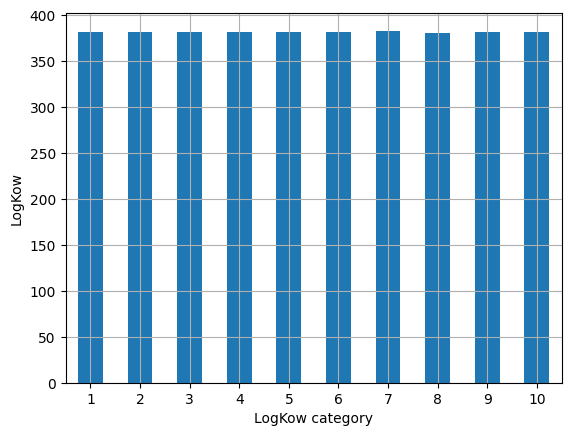

In [8]:
exploring_data['LogKow_categories'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("LogKow category")
plt.ylabel("LogKow")
plt.show()

In [9]:
exploring_data.head(10)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_urea,MID_N,MID_O,MID_H,MID_X,apol,bpol,LogS,Amenability,LogKow_categories
0,3.282407,0.173611,-0.229167,0.516994,12.857143,424.550,423.542,419.599511,44,0.156578,...,0,0.0,0.000000,8.293857,8.293857,19.256793,7.903207,-4.137362,False,8
1,3.261574,0.310185,0.310185,0.640241,11.000000,345.654,343.638,341.688998,38,0.091979,...,0,0.0,0.000000,6.650712,6.650712,16.873586,7.526414,-3.348831,False,7
2,3.816036,0.560326,0.560326,0.252201,45.000000,641.700,623.556,635.650873,108,0.027103,...,0,0.0,0.000000,10.513490,10.513490,50.342274,26.337726,-6.590764,False,10
3,3.263889,0.104167,-0.104167,0.591453,12.000000,345.654,343.638,341.688998,38,0.144115,...,0,0.0,0.000000,6.618718,6.618718,16.873586,7.526414,-3.705171,False,7
4,3.708519,0.636620,0.636620,0.570356,39.500000,427.800,415.704,423.767249,72,0.027366,...,0,0.0,0.000000,6.953121,6.953121,33.561516,17.558484,-4.613754,False,9
5,3.538009,0.438611,0.438611,0.716694,13.000000,263.960,255.896,261.899274,54,0.049156,...,0,0.0,0.000000,3.443758,3.443758,24.794344,10.785656,-3.799835,False,8
6,4.810764,0.550926,0.550926,0.383914,34.200000,136.976,131.936,135.952377,30,0.090595,...,0,0.0,1.852908,3.527576,1.674668,12.195965,8.132035,-1.167414,False,2
7,3.242708,0.956944,0.956944,0.488276,7.666667,213.900,207.852,211.883624,36,0.021188,...,0,0.0,0.000000,3.388325,3.388325,16.780758,8.779242,-2.490589,False,6
8,3.329514,1.137500,1.137500,0.501801,9.000000,215.916,207.852,213.899274,38,0.003154,...,0,0.0,0.000000,3.388325,3.388325,18.114344,10.785656,-3.210399,False,6
9,3.364236,1.152778,1.152778,0.513978,9.428571,229.943,219.863,227.914925,44,0.003126,...,0,0.0,0.000000,3.401269,3.401269,21.117930,12.792070,-3.615452,False,7


In [10]:
# Split the dataset into a stratified 80/20 partition (80% training and validation, 20% test)
data_train, data_test = train_test_split(
    exploring_data, 
    test_size=0.2,
    stratify=exploring_data['LogKow_categories'],
    random_state=42,
    shuffle=True
)

In [11]:
data_train_stratCategories=data_train['LogKow_categories'].copy()
data_train.drop('LogKow_categories', axis=1, inplace=True)
X_train=data_train.copy().drop(columns=['Amenability'])
y_train=data_train['Amenability'].copy()
train_idxs=X_train.index.to_list()

In [12]:
X_train.head()

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,MaxPartialCharge,...,fr_thiophene,fr_unbrch_alkane,fr_urea,MID_N,MID_O,MID_H,MID_X,apol,bpol,LogS
429,11.678775,0.229737,-0.229737,0.761548,11.466667,224.731,207.595,224.096793,82,0.138034,...,0,0,0,0.000000,1.736084,3.494568,1.758484,36.027481,18.432519,-4.383650
1590,11.231744,0.211157,-0.728305,0.544219,9.666667,206.241,192.129,206.094294,80,0.374085,...,0,0,0,0.000000,5.403072,5.403072,0.000000,31.781102,17.516898,-2.885842
762,9.570201,0.215289,-0.477083,0.636810,11.347826,306.361,288.217,306.125594,116,0.115096,...,0,0,0,0.000000,5.284210,5.284210,0.000000,47.808274,18.057726,-4.312014
625,13.547087,0.328919,-4.104974,0.627756,11.318182,352.775,338.663,352.040832,122,0.316205,...,0,0,1,7.563807,6.904608,20.197926,3.543652,40.950102,25.199898,-3.391017
11,5.308264,0.726204,0.726204,0.682198,9.300000,201.063,191.991,199.983677,54,0.118831,...,0,0,0,0.000000,1.990429,3.702316,1.711887,23.213137,12.144863,-3.047370


# Building feature preprocessing functions

## Defining feature transformers

In [13]:
power_transformation=PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
countFeatures=[feature for feature in list(X_train.columns) if feature.find("fr_")==0]+[feature for feature in list(X_train.columns) if feature.find("Num")>=0]+[feature for feature in list(X_train.columns) if feature.find("Coun")>=0]
realFeatures=list(set(X_train.columns)-set(countFeatures))

In [14]:
realNumerical_transformation_pipeline=Pipeline([
        ('imputer',SimpleImputer(strategy="median")),
        ("PowerTransform",power_transformation)
    ])

integerNumerical_transformation_pipeline=Pipeline([
        ('imputer',SimpleImputer(strategy="constant",fill_value=0)),
        ("PowerTransform",power_transformation)
    ])

In [15]:
preprocessing = ColumnTransformer([
    ("realStandarization",realNumerical_transformation_pipeline,realFeatures),
    ("integerStandarization",integerNumerical_transformation_pipeline,countFeatures)
],remainder='passthrough')

In [16]:
X_train_preprocesed=preprocessing.fit_transform(X_train)
X_train_preprocesed_df = pd.DataFrame(X_train_preprocesed, 
                                      columns=[featureName.split("__")[1] for featureName in preprocessing.get_feature_names_out()],
                                      index=train_idxs)
print(len(X_train_preprocesed_df))
display(X_train_preprocesed_df.head(5))

3055


,BCUT2D_MRHI,EState_VSA10,VSA_EState5,SMR_VSA2,Ipc,SMR_VSA9,SlogP_VSA2,EState_VSA11,Chi4v,SlogP_VSA1,...,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,HeavyAtomCount,NHOHCount,NOCount,RingCount
429,0.189473,0.141908,0.114837,-0.210819,0.162989,-0.624099,-0.811201,-0.025595,-0.002228,-0.736434,...,-0.962425,-0.652155,0.161469,-0.291989,-0.320762,-0.43228,0.270273,-0.944633,-0.933402,0.086309
1590,0.214320,0.683299,-0.662877,-0.210819,0.291826,-0.624099,0.202789,-0.025595,-0.173034,-0.736434,...,-0.962425,-0.194868,0.694910,-0.291989,-0.320762,-0.43228,0.270273,-0.944633,0.161536,0.086309
762,-0.567769,1.089120,0.368885,-0.210819,1.223254,1.685908,0.015862,-0.025595,0.867938,-0.736434,...,1.533122,-0.194868,0.161469,-0.291989,-0.320762,-0.43228,1.089528,1.459346,0.161536,1.402577
625,1.216166,1.438666,-0.974950,-0.210819,0.888601,-0.624099,0.612691,-0.025595,0.803986,1.585844,...,1.716518,1.642718,0.694910,-0.291989,-0.320762,-0.43228,1.007796,1.747682,1.540325,0.086309
11,1.740755,-1.286693,0.603399,-0.210819,-0.472984,1.544513,-0.223883,-0.025595,-0.579505,1.223090,...,-0.962425,-0.652155,0.161469,-0.291989,-0.320762,-0.43228,-0.573194,-0.944633,-0.933402,0.086309


## Feature dimensionality reduction

92 PCs explaining 95.1% of the total variance


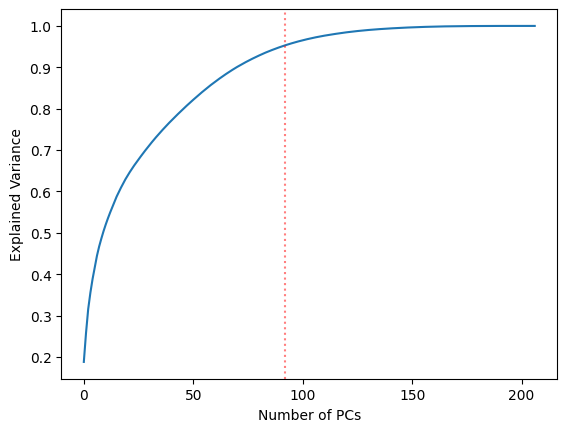

In [17]:
pca = PCA()
X_20D=pca.fit_transform(X_train_preprocesed_df)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
plt.plot(cumsum)
plt.axvline(x=d,color='red',linestyle = ':', alpha = 0.5,linewidth=1.5)
plt.xlabel(r"Number of PCs")
plt.ylabel(r"Explained Variance")
print(f"{d} PCs explaining {round(pca.explained_variance_ratio_[0:d].sum()*100,1)}% of the total variance")

In [18]:
pcaTransform = PCA(n_components=0.95)
X_pcaTranformed=pcaTransform.fit_transform(X_train_preprocesed)

In [19]:
# Save preprocessing transformers for model deployment
joblib.dump(preprocessing, os.path.join(MLModelsPath,"Amenability_columnsTransformers.vd.joblib"))
joblib.dump(pcaTransform, os.path.join(MLModelsPath,"Amenability_pcaTransformer.vd.joblib"))

['./models/amenability/Amenability_pcaTransformer.vd.joblib']

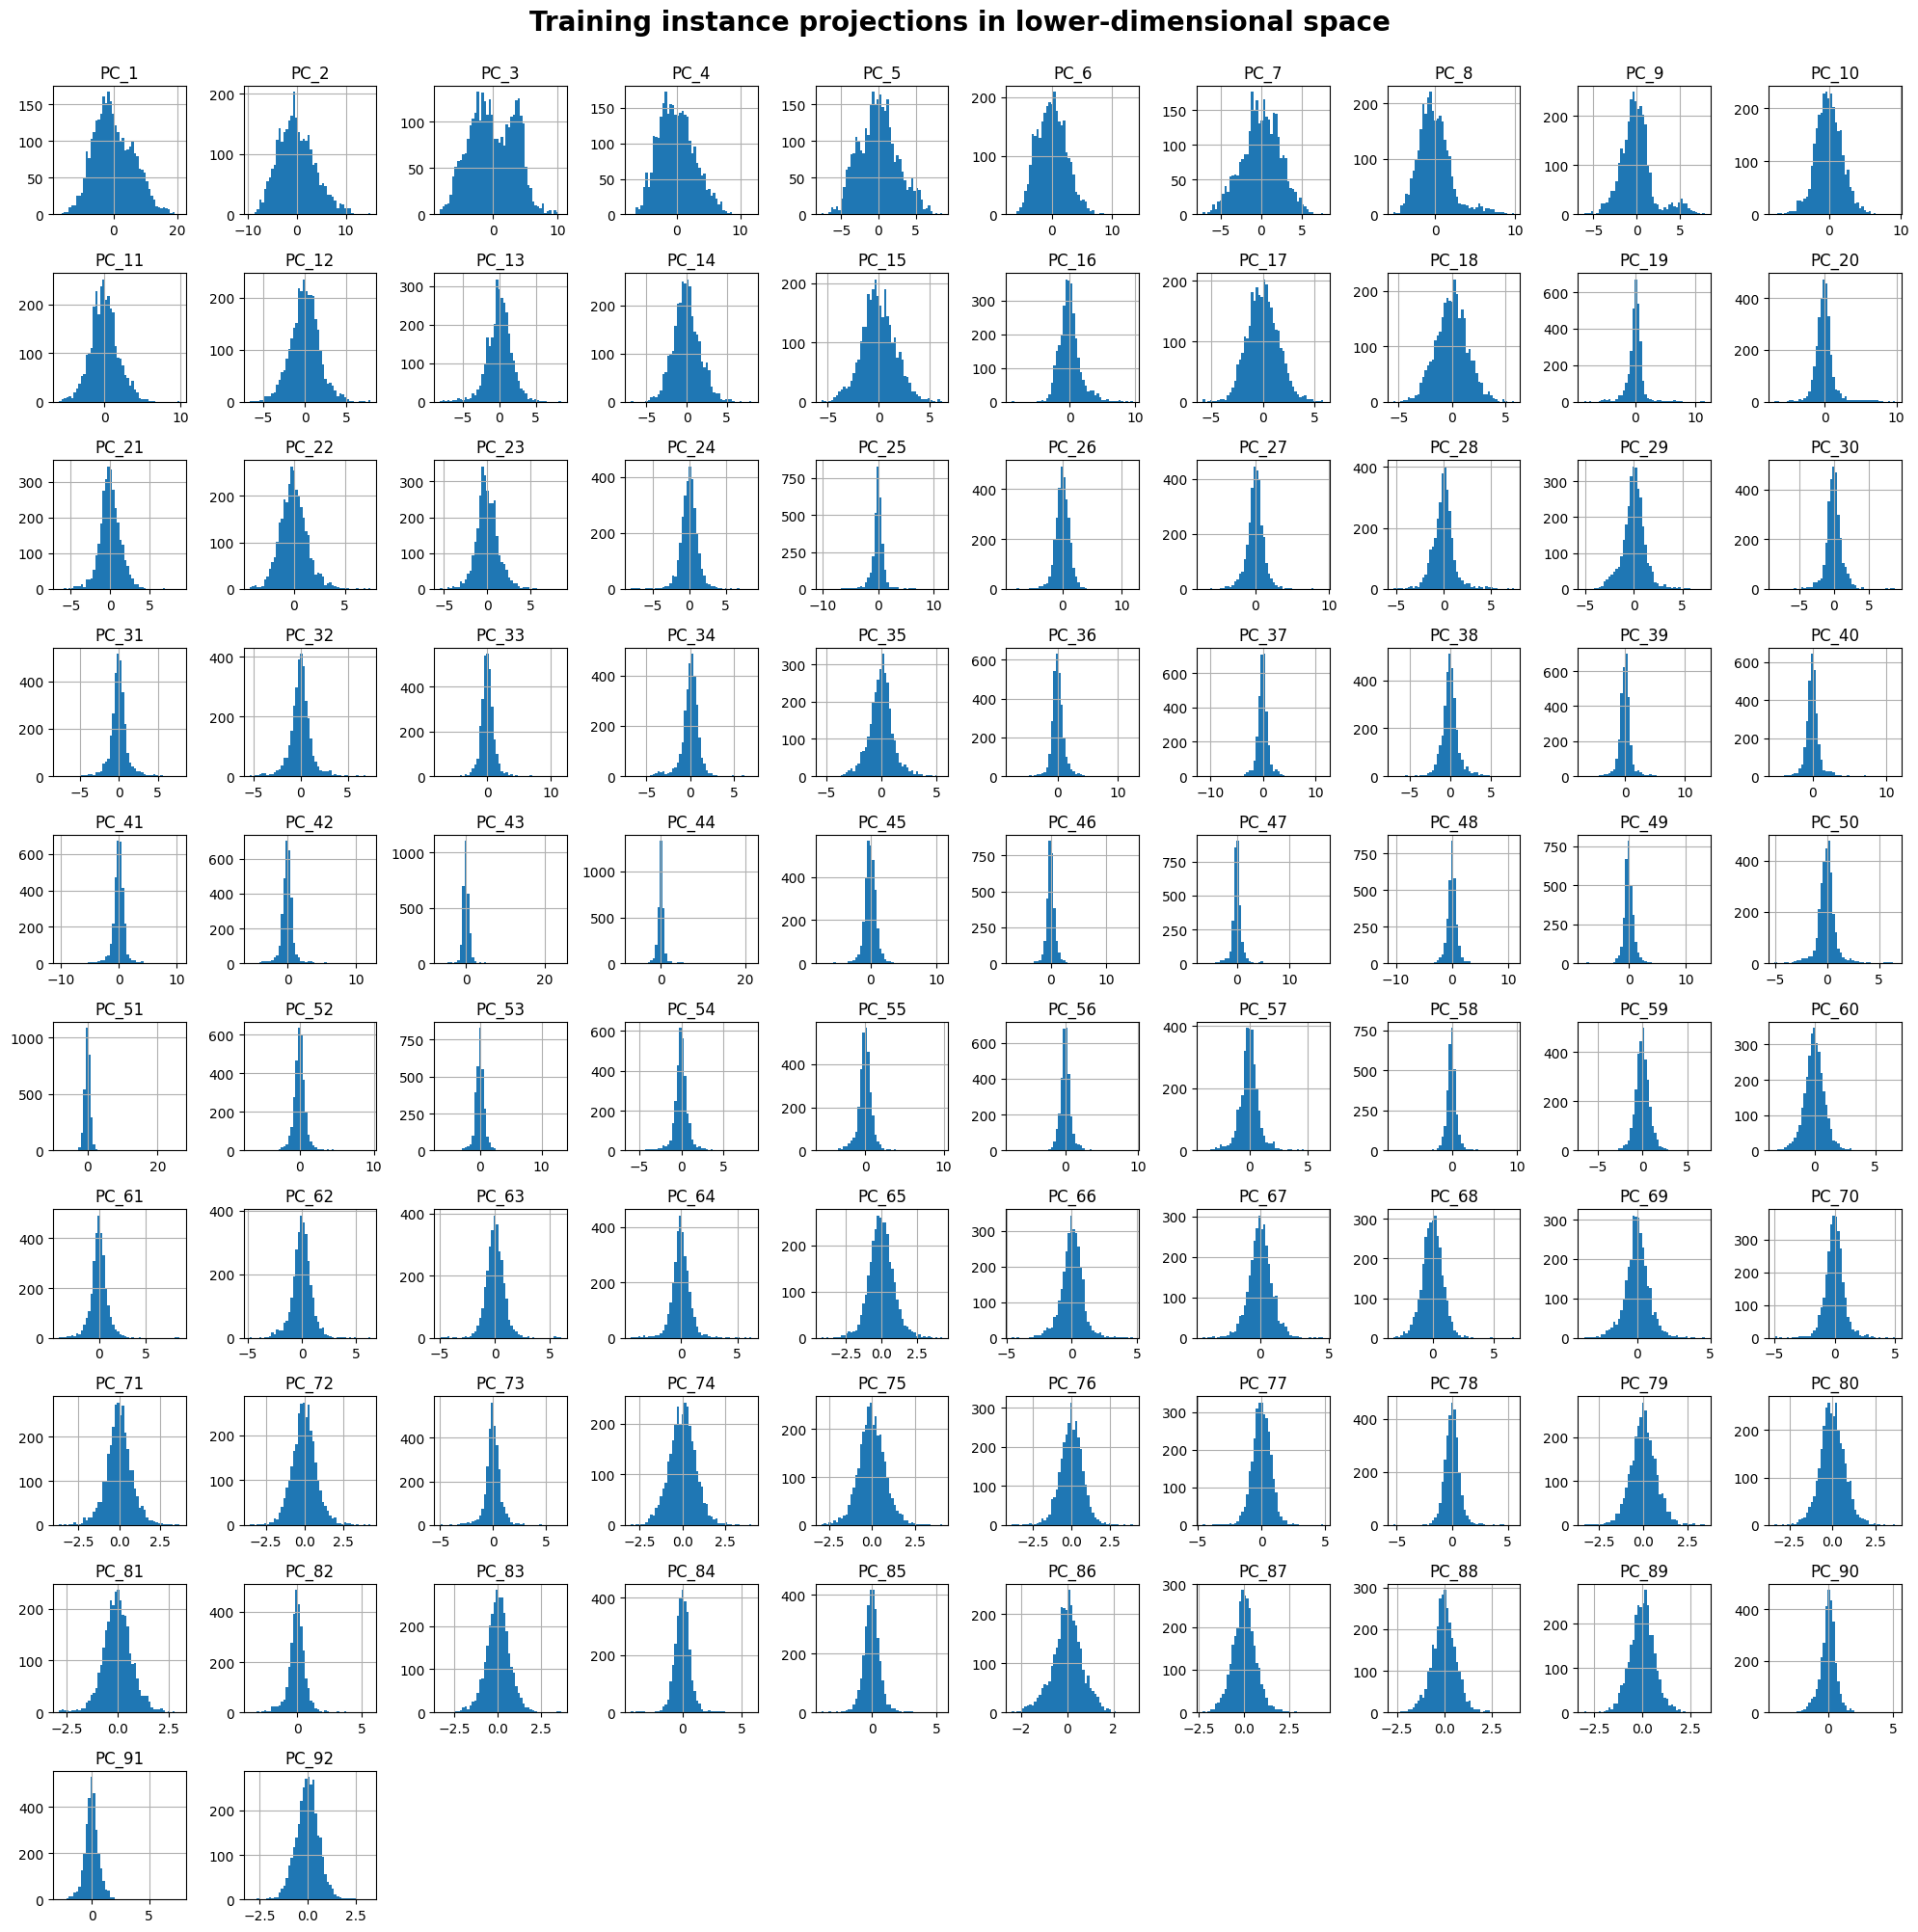

In [20]:
trainigDataFullTransformed=pd.DataFrame(X_pcaTranformed,columns=["PC_"+str(i+1) for i in range(0,np.shape(X_pcaTranformed)[1])])
trainigDataFullTransformed_names=list(trainigDataFullTransformed.columns)
plt_transf=trainigDataFullTransformed.hist(bins=50,figsize=(20,20))
plt.suptitle(r"Training instance projections in lower-dimensional space",fontweight='bold',size=20,y=1.0)
plt.tight_layout() 
plt.show()

# **RandomForestClassifier Hyperparameter Optimization and Model Fitting**

In [21]:
X_train_transformed=X_pcaTranformed
y_train_=y_train.copy().to_numpy()
print(len(X_train_transformed),len(y_train_))

3055 3055


In [22]:
# Random Forest Classifier hyperparameter optimization by grid search

isHyperparameterOpt=False
  
if isHyperparameterOpt:
    amenabilityClassifier=RandomForestClassifier() 
    grid_parameters=[{'n_estimators':[50,100,150,200,250],
                      'max_features':[1.0,0.75,0.5,0.25,0.1],
                      'criterion': ['log_loss', 'entropy', 'gini'],
                      'max_depth': [None],
                      'ccp_alpha': [0.00,0.005,0.01, 0.05,0.1],
                      'random_state':[42]
                  }]

    startTime = time.monotonic()
    grid_search=GridSearchCV(amenabilityClassifier, 
                             grid_parameters,
                             cv=5,
                             scoring=None,
                             n_jobs=6,
                             return_train_score=True)

    grid_search.fit(X_train_transformed,y_train_)
    elapsed_time = time.monotonic() - startTime
    print(f"Grid search elapsed time: {round(elapsed_time,2)} s")
    print(f"Best parameters: {grid_search.best_params_}\n")
    pd.DataFrame(grid_search.cv_results_).to_csv(os.path.join(modelEvalPath,"hp_searchResults_RF_model_amenability.vd.tsv"),sep="\t",index=False)
    pd.DataFrame.from_dict(grid_search.best_params_, orient='index').to_csv(os.path.join(modelEvalPath,"hp_optimalParameters_RT_model_amenability.vd.tsv"),sep="\t",index=True)
    print(f"Best score: {grid_search.best_score_}")

    #The optimal hyperparameters obtained through grid search are::
    __best_n_estimators=grid_search.best_params_['n_estimators']
    __best_max_features=grid_search.best_params_['max_features']
    __best_max_depth=grid_search.best_params_['max_depth']
    __best_criterion=grid_search.best_params_['criterion']
    __best_ccp_alpha=grid_search.best_params_['ccp_alpha']
else:
    # Best parameters: {'ccp_alpha': 0.0, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.25,
    # 'n_estimators': 250, 'random_state': 42}
    
    __best_n_estimators=250
    __best_max_features=0.25
    __best_max_depth=None
    __best_criterion='gini'
    __best_ccp_alpha=0.0



## **Model fitting using optimal hyperparameters**

In [23]:
amenabilityClassifier=RandomForestClassifier(max_features=__best_max_features,
                                                n_estimators=__best_n_estimators,
                                                criterion=__best_criterion,
                                                max_depth=__best_max_depth,
                                                ccp_alpha=__best_ccp_alpha,
                                                n_jobs=6,
                                                random_state=42)
amenabilityClassifier.fit(X_train_transformed,y_train_)


RandomForestClassifier(max_features=0.25, n_estimators=250, n_jobs=6,
                       random_state=42)

# **Model performance assessment**


## **Training Set Performance Assessment**

In [24]:
trainingScores=rTools.getMultiClassCrossValidationTrainingScores(amenabilityClassifier,
                                                    X_train_transformed,
                                                    y_train_,
                                                    n_folds=10,rand_seed=42,evalBinaryCurves=True)
trainingScores[0].to_csv(os.path.join(modelEvalPath,"crossValidationResults_Amenability_model_RF.vd.tsv"),sep="\t",index=False)
trainingScores[0]

,score,mean,std,U,n,data,label
0,Accuracy,92.7659,0.928484,0.664197,10.0,"[92.635, 93.617, 92.962, 91.653, 92.799, 91.48...",-
1,Recall(0),97.2339,0.902609,0.645687,10.0,"[96.596, 98.723, 97.234, 96.383, 95.957, 97.02...",-
2,Precision(0),93.6156,0.802906,0.574364,10.0,"[93.996, 93.36, 93.84, 93.018, 94.748, 92.308,...",-
3,F_1(0),95.387,0.59081,0.42264,10.0,"[95.278, 95.967, 95.507, 94.671, 95.349, 94.60...",-
4,Recall(1),77.8725,2.986554,2.136452,10.0,"[79.433, 76.596, 78.723, 75.887, 82.27, 73.05,...",-
5,Precision(1),89.5058,3.116744,2.229584,10.0,"[87.5, 94.737, 89.516, 86.29, 85.926, 88.034, ...",-
6,F_1(1),83.2368,2.21244,1.582684,10.0,"[83.272, 84.706, 83.773, 80.755, 84.058, 79.84...",-
7,MCC,0.789996,0.027838,0.019914,10.0,"[0.7871465708161023, 0.8145791118816665, 0.795...",-
8,AUCROC,0.968031,0.004967,0.003553,10.0,"[0.9675865763999999, 0.96159536605, 0.97187138...",-
9,AUCPRC,0.915357,0.008841,0.006325,10.0,"[0.91754937245, 0.9075172644, 0.91732860335, 0...",-


## **Test-set performance assessment**

In [25]:
X_test=data_test.copy().drop(columns=['Amenability'])
y_test=data_test['Amenability'].copy().to_numpy()
y_test=np.reshape(y_test,(len(y_test),1))
test_idxs=X_test.index.to_list()
X_test_transformed=pcaTransform.transform(preprocessing.transform(X_test))

In [26]:
test_pred_prob=amenabilityClassifier.predict_proba(X_test_transformed)
cfMtxSL=rTools.getSingleLabelContingenceMatrix(test_pred_prob,y_test[:,0])
display(cfMtxSL)
cfMtxSL.to_csv(os.path.join(modelEvalPath,"confMtx_test_Amenability_model_RF.vd.tsv"),sep="\t")
rTools.getSingleLabelMetrics(cfMtxSL)

target,0,1
prediction,,
0,563,43
1,16,142


,Accuracy,Recall(0),Precision(0),F_1(0),Recall(1),Precision(1),F_1(1),MCC
0,92.277,97.237,92.904,95.021,76.757,89.873,82.799,0.782624


In [27]:
inputDataSet=data_test.copy().drop(columns=['LogKow_categories'])
testStats=rTools.getTestMetricsStatistics(inputDataSet,yColumnName="Amenability",labelClass='Amenability',
                                            inputPreprocessing=preprocessing,
                                            inputTransformation=pcaTransform,
                                            inputModel=amenabilityClassifier,
                                            nCategories=10,
                                            stratificationColumn="MolLogP",
                                            mainAndComplementaryClasses=['Recall(1)','Recall(0)'],
                                           )

In [28]:
maxProbMetrics=rTools.getMetricsAverages(testStats,"maxValsMetrics")
maxProbMetrics.to_csv(os.path.join(modelEvalPath,"metrics_test_Amenability_model_RF.vd.tsv"),sep="\t",index=False)
maxProbMetrics

,score,mean,std,U,n,label
0,Accuracy,92.2775,1.72424,1.233447,10.0,-
1,Recall(0),97.2457,1.161366,0.830791,10.0,-
2,Precision(0),92.9081,1.269398,0.908072,10.0,-
3,F_1(0),95.0245,1.092612,0.781607,10.0,-
4,Recall(1),76.7389,4.210623,3.012098,10.0,-
5,Precision(1),89.7865,4.557091,3.259946,10.0,-
6,F_1(1),82.7282,4.132033,2.955879,10.0,-
7,MCC,0.782133,0.052005,0.037202,10.0,-


In [29]:
AUCs_averages=rTools.getAUCsAverages(testStats)
AUCs_averages.to_csv(os.path.join(modelEvalPath,"AUCs_test_Amenability_model_RF.vd.tsv"),sep="\t",index=False)
AUCs_averages

,score,mean,std,U,n,label
0,AUC(IMCP),0.695172,0.010241,0.007326,10.0,-
1,AUC(ROC),0.961217,0.012812,0.009165,10.0,-
2,AUC(PRC),0.925041,0.027084,0.019375,10.0,-


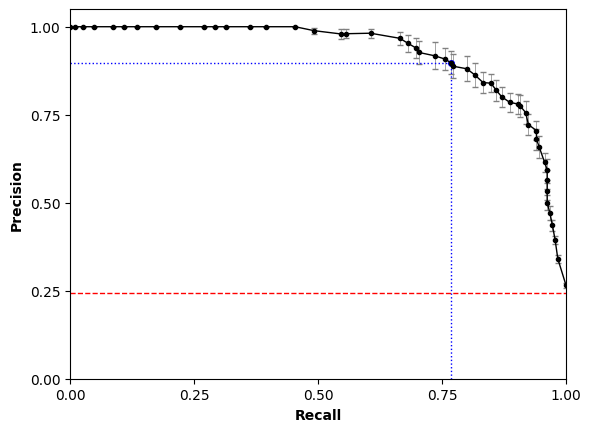

In [30]:
PRCs_averaged=rTools.getAveragePRC(testStats)
PRCs_averaged.to_csv(os.path.join(modelEvalPath,"PRC_test_Amenability_model_RF.vd.tsv"),sep="\t",index=False)
precision=maxProbMetrics[maxProbMetrics.score=="Precision(1)"]['mean'].iloc[0]/100
recall=maxProbMetrics[maxProbMetrics.score=="Recall(1)"]['mean'].iloc[0]/100
lprec=cfMtxSL.iloc[:,1].sum()/cfMtxSL.sum().sum()
plt.errorbar(PRCs_averaged.Recall_mean,PRCs_averaged.Precision_mean, yerr=PRCs_averaged.Precision_U,
            fmt='-o',markersize=3.0,linewidth=1,capsize=2, color='black', ecolor='gray', elinewidth=0.5, markerfacecolor='black')
plt.xlabel(r'Recall',fontweight='bold')
plt.ylabel(r'Precision',fontweight='bold')
plt.hlines(precision, xmin=0.0, xmax=recall, colors='blue', linestyles=':', linewidth=1.)
plt.vlines(recall, ymin=0.0, ymax=precision, colors='blue', linestyles=':', linewidth=1.)
plt.plot([recall], [precision], marker='o', color='blue', markersize=4)
plt.hlines(lprec, xmin=0.0, xmax=1., colors='red', linestyles='--', linewidth=1.)
plt.xticks(list(np.arange(0.0,1.05,0.25)))
plt.yticks(list(np.arange(0.0,1.05,0.25)))
plt.xlim(0,1)
plt.ylim(0,1.05)
plt.show()


# **Final model fitting using all training data**

In [31]:
X_allData=exploring_data.copy().drop(columns=['Amenability','LogKow_categories'])
y_allData=exploring_data['Amenability'].copy().to_numpy()
X_allData_transformed=pcaTransform.transform(preprocessing.transform(X_allData))
amenabilityClassifier_final=RandomForestClassifier(max_features=__best_max_features,
                                                n_estimators=__best_n_estimators,
                                                criterion=__best_criterion,
                                                max_depth=__best_max_depth,
                                                ccp_alpha=__best_ccp_alpha,
                                                n_jobs=6,
                                                random_state=42)
amenabilityClassifier_final.fit(X_allData_transformed,y_allData)
joblib.dump(amenabilityClassifier_final, os.path.join(MLModelsPath,"Amenability_RF_model.vd.joblib"))

['./models/amenability/Amenability_RF_model.vd.joblib']